## Targets
* modeling body keypoints and facial landmarks, apply DR(Dimensional Reduction), and resampling
    * keypoints come from Detectron2 COCO-keypoint model
    * facial landmarks come from Dlib model

In [25]:
import pickle
import json
from pathlib import Path
import numpy as np
import pandas as pd
import skimage.io as io
from sklearn.decomposition import PCA

In [3]:
!ls kp_heatmaps/keypoints/train | wc -l

22204


In [4]:
!ls AB_RGBA/train | wc -l

22204


In [37]:
KP_THRES = 0.05
NUM_DIM = 3

In [2]:
TRAIN_IMG_PATHS = sorted(list(Path('AB_RGBA/train').glob('*.png')))
KP_FILES = {p.stem: p for p in Path('kp_heatmaps/keypoints/train/').glob('*.pkl')}

DLIB_OUTPUTS = json.load(open('../df_landmarks.json', 'r'))
to_keep = [p.stem for p in TRAIN_IMG_PATHS]
LANDMARKS = {Path(item['in_the_wild']['file_path']).stem: np.array(item['in_the_wild']['face_landmarks']) 
             for item in DLIB_OUTPUTS.values() if Path(item['in_the_wild']['file_path']).stem in to_keep}

print(f"img: {len(TRAIN_IMG_PATHS)}, Keypoins: {len(KP_FILES)}, landmarks: {len(LANDMARKS)}")

img: 22204, Keypoins: 22204, landmarks: 22204


In [3]:
set(list(KP_FILES.keys())) == set([p.stem for p in TRAIN_IMG_PATHS]) and set([p.stem for p in TRAIN_IMG_PATHS]) == set(list(LANDMARKS.keys()))

True

## Visualization

In [4]:
from random import sample
import cv2
from PIL import Image
from IPython.display import display

In [95]:
SKELETON = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],[6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
def draw_skeletons(img, kps):
    for s, e in SKELETON:
        s -= 1
        e -= 1
        if kps.shape[-1] == 3 and (kps[s, 2] < KP_THRES or kps[e, 2] < KP_THRES):
            continue
#         print(type(kps[s, :2].astype(int).tolist()), kps[s, :2].astype(int).tolist())
        cv2.line(img, tuple(kps[s, :2].astype(int)), tuple(kps[e, :2].astype(int)), (0, 255, 0), 2)
    
def draw_keypoints(img, kps):
    for kp in kps:
        prob = None
        if len(kp) == 3:
            x, y, prob = kp
        else:
            x, y = kp

        if prob and prob < KP_THRES:
            continue
            
        x, y = int(x), int(y)
        cv2.circle(full, (x, y), 3, (0, 255, 0), -1)

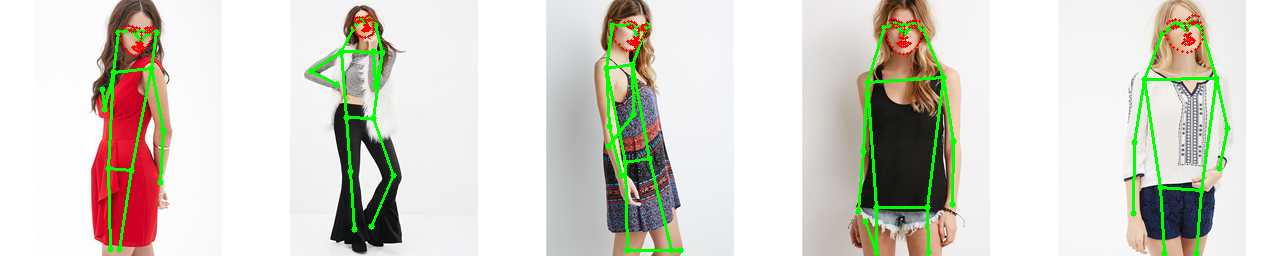

In [89]:
display_imgs = []
for p in sample(TRAIN_IMG_PATHS, 5):
    face, full = np.split(io.imread(p), 2, axis=1)
    
    # plot keypoints
    kps = pickle.load(open(KP_FILES[p.stem], 'rb'))
    assert kps.ndim == 3 and kps.shape[0] == 1, f"detection > 1 on {p.stem}"
    kps = kps[0]
    i = 0
    draw_keypoints(full, kps)
    draw_skeletons(full, kps)
    landmarks = np.cast['int32'](LANDMARKS[p.stem] * 0.25)
    for x, y in landmarks:
        cv2.circle(full, (x, y), 1, (255, 0, 0), -1)
    display_imgs.append(full)
display_imgs = np.array(display_imgs)
b, h, w, c = display_imgs.shape
display_imgs = display_imgs.transpose(1, 0, 2, 3).reshape(h, b*w, c)
display(Image.fromarray(display_imgs).convert('RGB'))

### COCO Keypoints
    "keypoints": [
        "nose","left_eye","right_eye","left_ear","right_ear",
        "left_shoulder","right_shoulder","left_elbow","right_elbow",
        "left_wrist","right_wrist","left_hip","right_hip",
        "left_knee","right_knee","left_ankle","right_ankle"
    ],
    "skeleton": [
        [16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],
        [6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]
    ]

In [260]:
headers = ["nose","left_eye","right_eye","left_ear","right_ear", "left_shoulder","right_shoulder","left_elbow","right_elbow",
           "left_wrist","right_wrist","left_hip","right_hip", "left_knee","right_knee","left_ankle","right_ankle"]
headers = [f"{name}_{xy}" for name in headers for xy in ['x', 'y']]
observations = []
for p in TRAIN_IMG_PATHS: # sample(TRAIN_IMG_PATHS, 20):
    kps = pickle.load(open(KP_FILES[p.stem], 'rb'))
    if kps.shape[0] > 1:
        # Detectron may predict >1 observations
        conf = kps[..., 2].sum(axis=-1)
        best_idx = conf.argmax()
        kps = kps[best_idx]
    else:
        kps = kps[0]
    observations.append(kps[:, :2].flatten())  # handle kp with low prob
observations = pd.DataFrame(observations, columns=headers)
observations

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,128.889114,23.417833,133.368393,18.619734,123.769958,19.259481,138.487564,21.178720,118.330833,21.818466,...,110.012184,114.901611,130.808823,177.276917,102.013496,176.317276,129.209076,231.015625,135.927979,217.261063
1,123.078262,35.028214,129.141220,24.791656,115.419769,29.909933,144.777298,25.111549,110.633217,35.667995,...,121.163643,166.184082,116.696190,214.807709,127.864822,237.520065,108.080391,249.675964,131.374954,249.675964
2,99.381989,31.371208,106.404350,25.615377,91.721222,27.214220,115.980309,32.010742,85.337242,35.208427,...,85.018044,147.766876,117.895508,238.900848,113.107529,237.302032,105.127556,252.650894,83.102852,169.511124
3,162.918259,28.780220,168.349075,25.261841,160.043106,23.662577,175.696671,27.500807,155.251205,26.541250,...,144.389542,110.662514,170.265839,171.114685,137.041962,173.033798,167.390701,221.331558,146.945236,221.011719
4,135.941772,30.223356,143.295853,21.268288,128.907425,25.745823,163.439667,22.227758,125.390251,31.502651,...,134.023315,196.851593,112.600533,251.221649,114.838737,251.221649,156.405319,251.221649,102.688507,251.221649
5,118.086777,33.514790,126.402748,24.559904,113.289101,29.037348,148.152222,25.519358,110.090652,33.194973,...,154.868988,184.148743,79.705360,250.350937,143.994232,250.350937,67.871086,250.350937,67.871086,250.350937
6,114.864410,30.698246,126.061417,24.938400,108.466133,24.298418,138.857986,33.578167,99.188614,33.578167,...,90.870834,214.373322,169.249847,252.132294,87.031860,252.132294,163.171478,214.053360,95.029724,252.132294
7,157.943985,35.820930,160.503601,30.062984,150.905014,28.143671,161.143509,35.501041,125.308769,31.662415,...,96.193031,209.838745,152.504776,251.423859,95.233185,251.423859,177.141174,212.077927,80.515335,213.037613
8,117.712669,35.894817,127.940094,30.138250,112.918564,29.498634,144.559662,36.214622,105.887207,33.975960,...,109.402885,207.312469,128.898926,250.486694,105.887207,250.486694,146.796921,250.486694,127.940094,250.486694
9,111.380692,36.055031,121.281113,29.019562,105.951424,29.659149,139.485123,31.577915,101.480263,32.217503,...,111.061325,207.464676,137.568909,251.596283,120.323006,251.596283,146.511230,251.596283,121.600487,251.596283


In [61]:
# keep global mean, std?
mu, sigma = observations.mean(axis=0), observations.std(axis=0)
observations = (observations - mu) / sigma

In [62]:
embed = PCA(n_components=NUM_DIM, svd_solver='full')
embed.fit(observations)

PCA(n_components=3, svd_solver='full')

In [63]:
V = embed.components_.transpose()
V.shape

(34, 3)

In [64]:
V = V / np.linalg.norm(V, axis=0, keepdims=True)

resample_latents:  (5, 34)


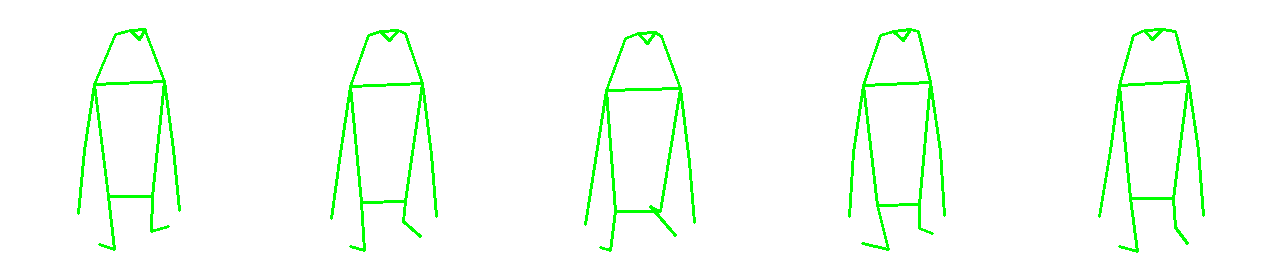

In [273]:
# resampling
BATCH_SIZE = 5
z = np.random.randn(BATCH_SIZE, NUM_DIM)
resample_latents = z @ V.T
resample_latents = resample_latents * sigma[None, :] + mu[None, :]

print("resample_latents: ", resample_latents.shape)

display_imgs = []
resample_kps = resample_latents.reshape(-1, 17, 2)
for kps in resample_kps:
    canvas = np.ones((256,256,3), dtype=np.uint8) * 255
    draw_keypoints(canvas, kps)
    draw_skeletons(canvas, kps)
    display_imgs.append(canvas)
display_imgs = np.array(display_imgs)
b, h, w, c = display_imgs.shape
display_imgs = display_imgs.transpose(1, 0, 2, 3).reshape(h, b*w, c)
display(Image.fromarray(display_imgs).convert('RGB'))

## TODO
* 和 face landmarks & bounding box coords. 一起 re-sampling
* 根據 sample 出的點求 transformation matrix
* 對 stylegan2-ada outputs 做 Inverse transformation 得到 masked face-fullbody

## Resampling from minibatch

In [268]:
bs = 4
batch_data = observations.sample(bs ** 2, axis=0).to_numpy().reshape(bs, bs, -1)
resample_latents = []
for data in batch_data:
    # local mean & std
    mu, sigma = data.mean(axis=0), data.std(axis=0)
    data = (data - mu) / sigma
    
    embed = PCA(n_components=bs-1, svd_solver='full')
    embed.fit(data)
    V = embed.components_.transpose()
    V = V / np.linalg.norm(V, axis=0, keepdims=True)
    
    z = np.random.randn(NUM_DIM)
    resample_latent = z @ V.T
    resample_latents.append(resample_latent * sigma + mu)
resample_latents = np.stack(resample_latents, axis=0)
print(resample_latents.shape)

(4, 34)


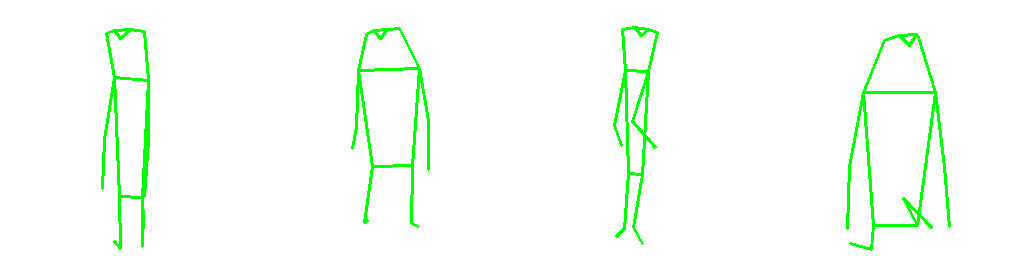

In [269]:
display_imgs = []
resample_kps = resample_latents.reshape(-1, 17, 2)
for kps in resample_kps:
    canvas = np.ones((256,256,3), dtype=np.uint8) * 255
    draw_keypoints(canvas, kps)
    draw_skeletons(canvas, kps)
    display_imgs.append(canvas)
display_imgs = np.array(display_imgs)
b, h, w, c = display_imgs.shape
display_imgs = display_imgs.transpose(1, 0, 2, 3).reshape(h, b*w, c)
display(Image.fromarray(display_imgs).convert('RGB'))